# Sparkify 流失用户预测
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
import pyspark

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from sklearn.utils import shuffle
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf

import re
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

##Other Installment
#import os
#os.environ['JAVA_HOME']='/Users/mialu/opt/anaconda3/pkgs/java-jdk-8.25.17-0/'

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Final Project") \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [4]:
data = 'mini_sparkify_event_data.json'
df = spark.read.json(data)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [6]:
get_hour = udf(lambda x:datetime.datetime.fromtimestamp(x/1000.0). hour)
df = df.withColumn("hour",get_hour(df.ts))

In [7]:
# 清除 用户名为 ''
df_valid = df.filter(df["userId"]!="")
df.count()
df_valid.count()
user_log = df_valid

In [8]:
## 定义流失客户，churn设置为1
flag_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log = user_log.withColumn("churn", flag_churn("page"))
## 找到有churn = 1的 userId,即流失的客户的Id
userId_churn = user_log.select(['userId']).where(user_log.churn == 1).collect()
userId_churn_list = []
for i in range(len(userId_churn)):
    userId_churn_list.append(userId_churn[i][0])

- 统计一共有多少 userId, 
- 流失率是多少，
- 新建2个数据集，分别保存流失客户的数据 和 留存客户的数据。

In [9]:
print('共有userId',len(user_log.select('userId').distinct().collect()),'个')
print('流失的userId',len(userId_churn),'个')
print("流失率",len(userId_churn)/len(user_log.select('userId').distinct().collect()))

共有userId 225 个
流失的userId 52 个
流失率 0.2311111111111111


In [10]:
# 得到 churn用户的 DF
def getrows_churn(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[0]['userId'] in rownums).map(lambda x: x[0])
df_churn = getrows_churn(user_log,userId_churn_list).toDF()

# 得到 留存用户的 DF
def getrows_stay(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[0]['userId'] not in rownums).map(lambda x: x[0])
df_stay = getrows_stay(user_log,userId_churn_list).toDF()

In [11]:
pd_churn = df_churn.toPandas()
pd_stay = df_stay.toPandas()

In [12]:
# 最新ts
print(datetime.datetime.fromtimestamp(pd_churn.ts.max()/1000))
print(datetime.datetime.fromtimestamp(pd_churn.ts.min()/1000))
print(datetime.datetime.fromtimestamp(pd_stay.ts.max()/1000))
print(datetime.datetime.fromtimestamp(pd_stay.ts.min()/1000))

2018-11-29 19:45:09
2018-10-01 08:32:10
2018-12-03 09:11:16
2018-10-01 08:01:57


In [13]:
# 随意挑 2个用户 ，看该用户的活动时间
print(datetime.datetime.fromtimestamp(pd_churn[pd_churn.userId == '18'].ts.max()/1000))
print(datetime.datetime.fromtimestamp(pd_churn[pd_churn.userId == '18'].ts.min()/1000))
print(datetime.datetime.fromtimestamp(pd_churn[pd_churn.userId == '125'].ts.max()/1000))
print(datetime.datetime.fromtimestamp(pd_churn[pd_churn.userId == '125'].ts.min()/1000))

2018-10-08 04:26:30
2018-10-03 01:05:17
2018-10-12 12:35:18
2018-10-12 12:05:44


# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 统计，每个用户的`总活跃次数`，即 user log中每个用户的条目数量。

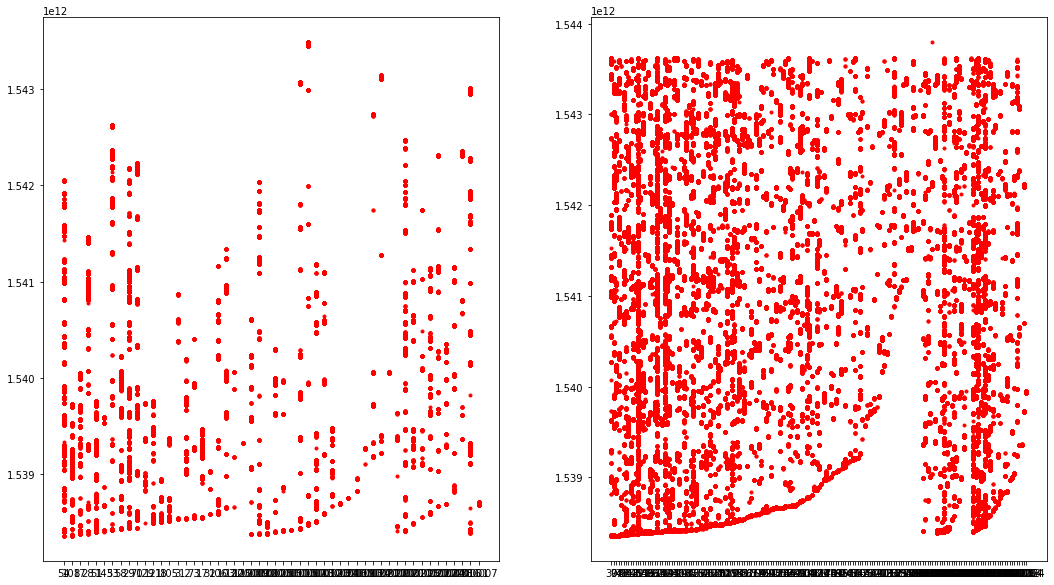

In [14]:
# Note: 散点图 表示 流失用户的活跃时间，留存用户的活跃log(user_log记录的时间ts)。
# Note:  横轴：用户Id； 纵轴：ts

# 流失用户的活跃log
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(1,2,1)  
x = pd_churn.userId
y = pd_churn.ts
ax1.scatter(x,y,c = 'r',marker = '.')  

# 留存用户的活跃log
ax2 = fig.add_subplot(1,2,2)  
x = pd_stay.userId
y = pd_stay.ts
ax2.scatter(x,y,c = 'r',marker = '.')

## 保存用户活跃次数
# pd_churn
churn_active_keys = pd_churn.groupby('userId').ts.count().index.values
churn_active_values = pd_churn.groupby('userId').ts.count().values
# pd_stay
stay_active_keys = pd_stay.groupby('userId').ts.count().index.values
stay_active_values = pd_stay.groupby('userId').ts.count().values

### 统计 pd_churn 和 pd_stay 中，每个用户的 `活跃时长`（max(ts)-min(ts)）

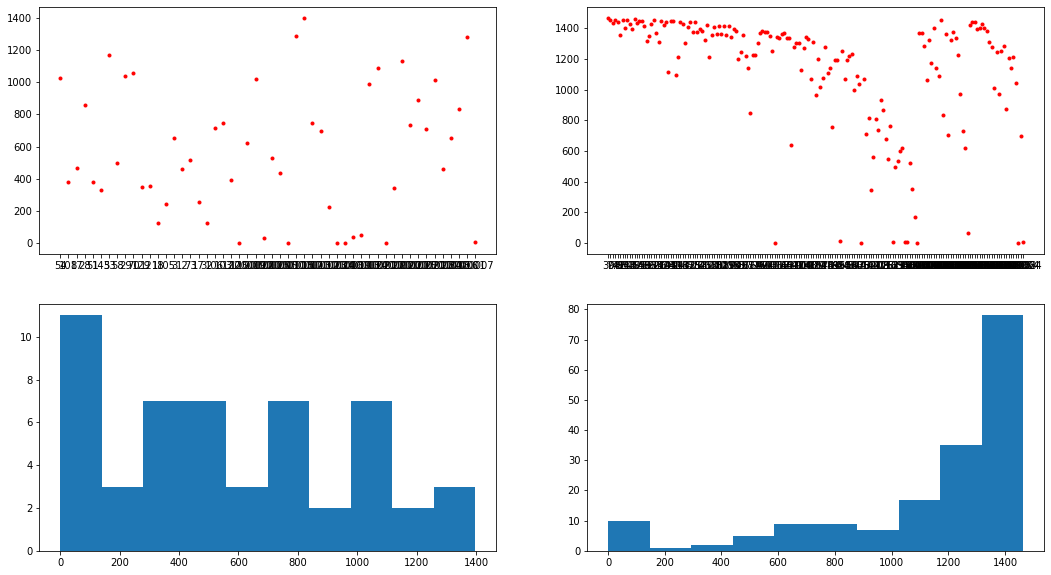

In [15]:
# 统计 pd_churn 和 pd_stay 中，每个用户的 活跃时长（max(ts)-min(ts)）

# 对给定用户userID和df,给出该用户的活跃时长
def user_maxmin_ts(userId, df):
    user1_ts = df[df.userId == userId].ts
    user1_max_ts = datetime.datetime.fromtimestamp(user1_ts.max()/1000)
    user1_min_ts = datetime.datetime.fromtimestamp(user1_ts.min()/1000)
    temp = user1_max_ts - user1_min_ts
    return temp.days*24+temp.seconds/3600

pd_churn_maxmin_ts = []
for i in pd_churn.userId.unique():
    pd_churn_maxmin_ts.append(user_maxmin_ts(i,pd_churn))
    
pd_stay_maxmin_ts = []
for i in pd_stay.userId.unique():
    pd_stay_maxmin_ts.append(user_maxmin_ts(i,pd_stay))
    

# 流失用户的活跃时间
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(2,2,1);  
x = pd_churn.userId.unique()
y = pd_churn_maxmin_ts
ax1.scatter(x,y,c = 'r',marker = '.')  
# 直方图表示
ax3 = fig.add_subplot(2,2,3)
plt.hist(y)

# 保存churn的 active Time
churn_activeTime_keys = pd_churn.userId.unique()
churn_activeTime_values = y

# 留存用户的活跃时间
ax2 = fig.add_subplot(2,2,2)  
x = pd_stay.userId.unique()
y = pd_stay_maxmin_ts
ax2.scatter(x,y,c = 'r',marker = '.')
# 直方图表示
ax4 = fig.add_subplot(2,2,4)
plt.hist(y)

# 保存stay的 active Time
stay_activeTime_keys = pd_stay.userId.unique()
stay_activeTime_values = y


### 统计用户的 `page`状态

In [16]:
churn_pages = pd_churn['userId'].groupby([pd_churn['userId'],pd_churn['page']]).count().unstack().fillna(0)
stay_pages = pd_stay['userId'].groupby([pd_stay['userId'],pd_stay['page']]).count().unstack().fillna(0)

In [17]:
churn_page_unique = [i for i in churn_pages.mean().index.values if i not in stay_pages.mean().index.values]
print(churn_page_unique)

# 把 `Cancel`和`Cancellation Confirmation`从特征工程中去除。
churn_pages.drop(churn_page_unique,axis=1,inplace=True)

['Cancel', 'Cancellation Confirmation']


In [18]:
churn_pages.mean().index.values

array(['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error',
       'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert',
       'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade',
       'Thumbs Down', 'Thumbs Up', 'Upgrade'], dtype=object)

### 创建数据集：包含用户的`page状态`、`活跃时长`、`活跃次数`及`流失标签`

In [19]:
new_df = churn_pages.append(stay_pages)

active_keys = churn_active_keys.tolist() + stay_active_keys.tolist()
active_values = churn_active_values.tolist() + stay_active_values.tolist()
activeTime_keys = churn_activeTime_keys.tolist() + (stay_activeTime_keys.tolist())
activeTime_values = churn_activeTime_values + (stay_activeTime_values)

new_df['active_counts'] = active_values
new_df['active_time'] = activeTime_values

# 加入 gender. Female设为1，male设为0 
gender_churn = []
for i in pd_churn.userId.unique():
    gender_churn.append(int(pd_churn[pd_churn.userId == i].gender.unique()=='F'))
gender_stay = []
for i in pd_stay.userId.unique():
    gender_stay.append(int(pd_stay[pd_stay.userId == i].gender.unique()=='F'))
new_df['gender'] = gender_churn + gender_stay

# 加入 active_counts/active_time作为变量
new_df['active_freq'] = new_df['active_counts']/new_df['active_time']

# 加入label
new_df['label'] = list([1]*len(churn_pages) + [0]*len(stay_pages))

# reset Index
new_df.reset_index(inplace=True)

In [20]:
# Python DataFrame类型 转为 Pyspark DataFrame
from sklearn.utils import shuffle
new_df = shuffle(new_df)

df_values = new_df.values.tolist()
df_columns = list(new_df.columns)
spark_df = spark.createDataFrame(df_values, df_columns)


feature_list = spark_df.columns[1:-1]
assembler = VectorAssembler(inputCols = feature_list, outputCol = 'NumFeatures')
df = assembler.transform(spark_df)

# 归一化向量
scaler = Normalizer(inputCol =  'NumFeatures', outputCol = 'features')
df =  scaler.transform(df)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [21]:
# 划分train, test, validation 数据集
train, test = df.select('features','label').randomSplit([0.75, 0.25], seed=42)
train, validation = train.randomSplit([0.75, 0.25], seed=42)

# 查看划分后的数据
train.groupBy('label').count().show()
validation.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  106|
|    1|   33|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   27|
|    1|   10|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   40|
|    1|    9|
+-----+-----+



In [22]:
# 因为不同的分类方法的结果中，自带评估函数不同，所以，这里·定义·评估函数 precision, recall 和  F1-score
def f1score_model(model_results):
    model_results.filter(model_results['label']==1).filter(model_results['prediction']==1)
    trueP = model_results.filter(model_results['label']==1).filter(model_results['prediction']==1).count()
    believeP = model_results.filter(model_results['prediction']==1).count()
    realP = model_results.filter(model_results['label']==1).count()
    trueN = model_results.filter(model_results['label']==0).filter(model_results['prediction']==0).count()
    precisionM = trueP/believeP
    recallM = trueP/realP
    accuracyM = (trueP+trueN)/(model_results.count())
    f1M = 2*(precisionM * recallM)/(precisionM + recallM)
    evaluateM = {'precision':[precisionM],'accuracy':[accuracyM],'recall':[recallM],'f1score':[f1M]}
    result = pd.DataFrame(evaluateM)
    return result


# ··········逻辑回归··········
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(labelCol = 'label').fit(train)

### 在测试数据集中评估模型，返回对象为BinaryLogisticRegressionSummary- 给定模型的二元逻辑回归结果
train_results = log_reg.evaluate(train).predictions
val_results = log_reg.evaluate(validation).predictions

print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall  f1score
0   0.967742  0.971223  0.909091   0.9375
验证集效果    precision  accuracy  recall   f1score
0      0.875  0.891892     0.7  0.777778


In [23]:
# ··········决策树··············
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=10, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


In [24]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
paramGrid = ParamGridBuilder().addGrid(dt.impurity, ["gini", "entropy"]).addGrid(dt.maxDepth, [5, 10, 15]).addGrid(dt.maxBins, [10, 15, 20]).build()
# 在训练集找到最好的参数

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
tsv = TrainValidationSplit(estimator=dt, evaluator = evaluator, estimatorParamMaps=paramGrid, trainRatio=0.8)
temp_model = tsv.fit(train)
bestModel = temp_model.bestModel #找出最好的模型

temp_model = bestModel
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall   f1score
0   0.964286   0.94964  0.818182  0.885246
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


## 检查模型是否ROBUST

## 重新划分 数据集 -training size基本不变

In [25]:
# 划分train, test, validation 数据集
train, test = df.select('features','label').randomSplit([0.75, 0.25], seed=40)
train, validation = train.randomSplit([0.75, 0.25], seed=40)

# 查看划分后的数据
train.groupBy('label').count().show()
validation.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   93|
|    1|   29|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   35|
|    1|   10|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   45|
|    1|   13|
+-----+-----+



In [26]:
# ··········逻辑回归··········
log_reg = LogisticRegression(labelCol = 'label').fit(train)

### 在测试数据集中评估模型，返回对象为BinaryLogisticRegressionSummary- 给定模型的二元逻辑回归结果
train_results = log_reg.evaluate(train).predictions
val_results = log_reg.evaluate(validation).predictions

print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall   f1score
0   0.913043  0.918033  0.724138  0.807692
验证集效果    precision  accuracy  recall   f1score
0   0.545455       0.8     0.6  0.571429


In [27]:
# ··········决策树··············
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=10, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


## 再次划分数据集 - 减小training size

In [28]:
# 划分train, test, validation 数据集
train, test = df.select('features','label').randomSplit([0.75, 0.25], seed=40)
train, validation = train.randomSplit([0.5, 0.5], seed=40)

# 查看划分后的数据
train.groupBy('label').count().show()
validation.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   62|
|    1|   17|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   66|
|    1|   22|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   45|
|    1|   13|
+-----+-----+



In [29]:
# ··········逻辑回归··········
log_reg = LogisticRegression(labelCol = 'label').fit(train)

### 在测试数据集中评估模型，返回对象为BinaryLogisticRegressionSummary- 给定模型的二元逻辑回归结果
train_results = log_reg.evaluate(train).predictions
val_results = log_reg.evaluate(validation).predictions

print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall   f1score
0   0.857143  0.911392  0.705882  0.774194
验证集效果    precision  accuracy    recall   f1score
0   0.529412  0.761364  0.409091  0.461538


In [30]:
# ··········决策树··············
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=10, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


# (ΩДΩ)震惊 决策树的效果就是超级好

In [31]:
# 划分train, test, validation 数据集
train, test = df.select('features','label').randomSplit([0.75, 0.25], seed=42)
train, validation = train.randomSplit([0.3, 0.7], seed=40)

# 查看划分后的数据
train.groupBy('label').count().show()
validation.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   41|
|    1|    9|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   92|
|    1|   34|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   40|
|    1|    9|
+-----+-----+



In [32]:
# ··········逻辑回归··········
log_reg = LogisticRegression(labelCol = 'label').fit(train)

### 在测试数据集中评估模型，返回对象为BinaryLogisticRegressionSummary- 给定模型的二元逻辑回归结果
train_results = log_reg.evaluate(train).predictions
val_results = log_reg.evaluate(validation).predictions

print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0
验证集效果    precision  accuracy    recall   f1score
0   0.258065  0.611111  0.235294  0.246154


In [33]:
# ··········决策树··············
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=10, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


# (ΩДΩ)再次震惊 决策树的效果就是超级好

## 为什么决策树的niubility这么好，我们看一下决策树中，各个feature在预测上的重要性吧~

In [34]:
#·············重新使用 第一次预测使用的数据集···················
# 划分train, test, validation 数据集
train, test = df.select('features','label').randomSplit([0.75, 0.25], seed=42)
train, validation = train.randomSplit([0.75, 0.25], seed=42)

# 查看划分后的数据
train.groupBy('label').count().show()
validation.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  106|
|    1|   33|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   27|
|    1|   10|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   40|
|    1|    9|
+-----+-----+



In [35]:
# ··········决策树··············
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=10, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


### 分析决策树的features Importance

In [36]:
features_notUsed_indices = [i  for i in list(range(20)) if i not in temp_model.featureImportances.indices.tolist()]
features_notUsed = [feature_list[i] for i in features_notUsed_indices]
print(features_notUsed)

['Add to Playlist', 'Error', 'Help', 'Home', 'Logout', 'Settings', 'Submit Downgrade', 'Upgrade', 'active_counts', 'active_time', 'gender']


<BarContainer object of 10 artists>

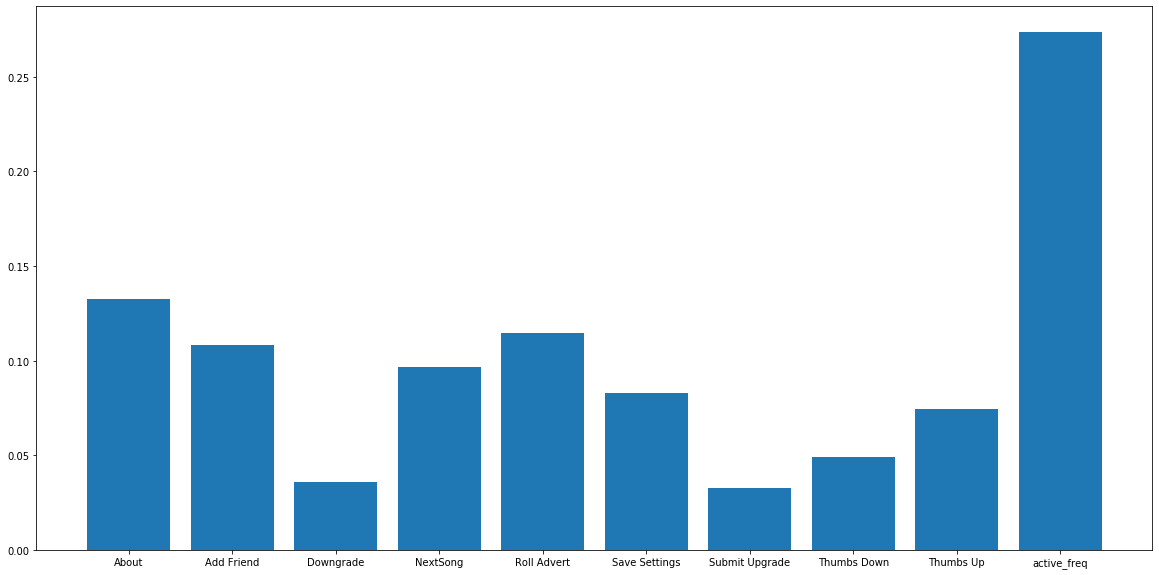

In [37]:
features_used = [feature_list[i] for i in temp_model.featureImportances.indices]
features_weight = temp_model.featureImportances.values
plt.figure(figsize = (20,10))
plt.bar(features_used, features_weight)

In [38]:
temp = sorted(zip(features_weight,features_used), reverse = True)

<BarContainer object of 10 artists>

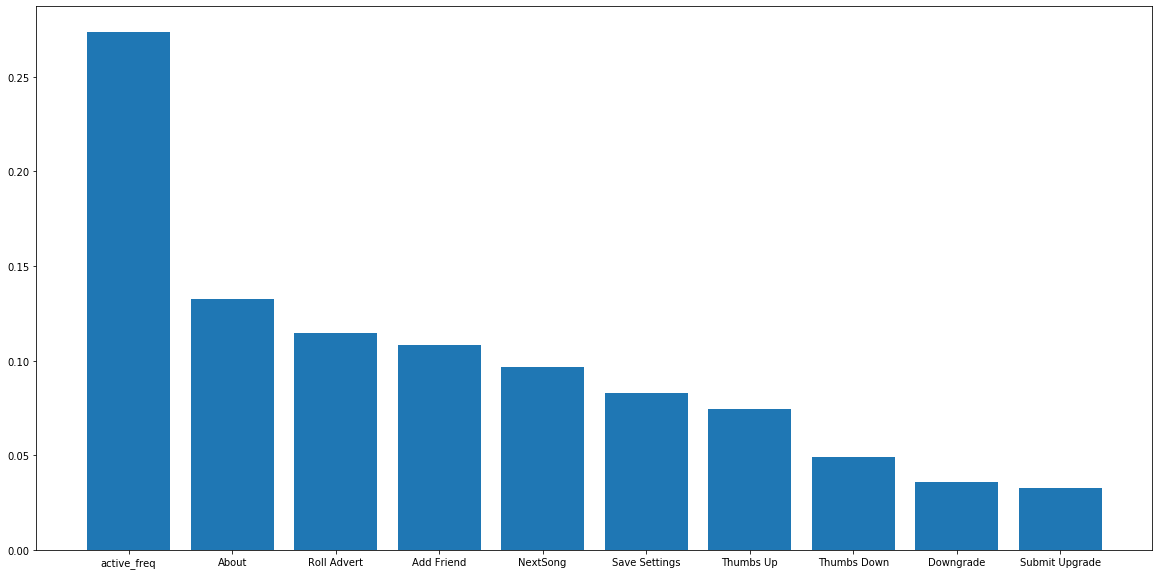

In [39]:
temp_index = [temp[i][0] for i in range(len(temp))]
temp_value = [temp[i][1] for i in range(len(temp))]
plt.figure(figsize = (20,10))
plt.bar(temp_value, temp_index)

In [40]:
temp_value

['active_freq',
 'About',
 'Roll Advert',
 'Add Friend',
 'NextSong',
 'Save Settings',
 'Thumbs Up',
 'Thumbs Down',
 'Downgrade',
 'Submit Upgrade']

In [58]:
temp = churn_pages[temp_value[1:10]]
temp

page,About,Roll Advert,Add Friend,NextSong,Save Settings,Thumbs Up,Thumbs Down,Downgrade,Submit Upgrade
userId,,,,,,,,,
100001,0.0,14.0,2.0,133.0,0.0,8.0,2.0,0.0,0.0
100003,0.0,9.0,0.0,51.0,0.0,3.0,0.0,0.0,0.0
100005,0.0,18.0,3.0,154.0,0.0,7.0,3.0,0.0,0.0
100006,0.0,3.0,4.0,26.0,0.0,2.0,2.0,0.0,0.0
100007,0.0,5.0,17.0,423.0,1.0,19.0,6.0,7.0,0.0
100009,1.0,42.0,7.0,518.0,1.0,23.0,8.0,5.0,1.0
100011,0.0,2.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0
100012,1.0,38.0,2.0,476.0,0.0,18.0,9.0,4.0,1.0
100013,2.0,39.0,28.0,1131.0,3.0,39.0,15.0,13.0,1.0


In [65]:
temp.mean()

page
About               1.076923
Roll Advert        18.596154
Add Friend         12.230769
NextSong          699.884615
Save Settings       1.115385
Thumbs Up          35.750000
Thumbs Down         9.538462
Downgrade           6.480769
Submit Upgrade      0.615385
dtype: float64

In [67]:
temp.median()

page
About               1.0
Roll Advert        11.0
Add Friend         10.5
NextSong          452.5
Save Settings       1.0
Thumbs Up          19.5
Thumbs Down         7.0
Downgrade           4.0
Submit Upgrade      1.0
dtype: float64

In [44]:
temp = stay_pages[temp_value[1:10]]
temp.mean()

page
About                2.537572
Roll Advert         17.144509
Add Friend          21.046243
NextSong          1108.173410
Save Settings        1.456647
Thumbs Up           61.803468
Thumbs Down         11.849711
Downgrade            9.930636
Submit Upgrade       0.734104
dtype: float64

In [45]:
temp.median()

page
About               1.0
Roll Advert        11.0
Add Friend         16.0
NextSong          747.0
Save Settings       1.0
Thumbs Up          41.0
Thumbs Down         8.0
Downgrade           6.0
Submit Upgrade      1.0
dtype: float64

In [46]:
temp

page,About,Roll Advert,Add Friend,NextSong,Save Settings,Thumbs Up,Thumbs Down,Downgrade,Submit Upgrade
userId,,,,,,,,,
10,2.0,1.0,12.0,673.0,1.0,37.0,4.0,7.0,0.0
100,12.0,25.0,49.0,2682.0,5.0,148.0,27.0,30.0,1.0
100002,0.0,3.0,1.0,195.0,0.0,5.0,0.0,2.0,0.0
100004,0.0,86.0,19.0,942.0,2.0,35.0,11.0,10.0,3.0
100008,3.0,20.0,17.0,772.0,0.0,37.0,6.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...
95,4.0,50.0,32.0,1694.0,0.0,91.0,25.0,15.0,0.0
96,3.0,17.0,40.0,1802.0,1.0,92.0,24.0,20.0,1.0
97,5.0,24.0,32.0,1975.0,2.0,108.0,12.0,17.0,1.0


## 补充：churn和stay的  'page' 数据可视化

In [47]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled_churn = pd.DataFrame(min_max_scaler.fit_transform(churn_pages))
np_scaled_stay = pd.DataFrame(min_max_scaler.fit_transform(stay_pages))

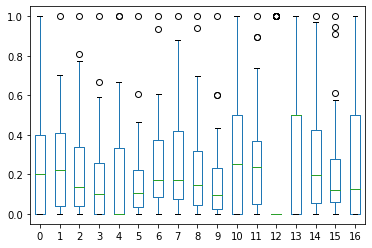

In [48]:
np_scaled_churn.plot.box()

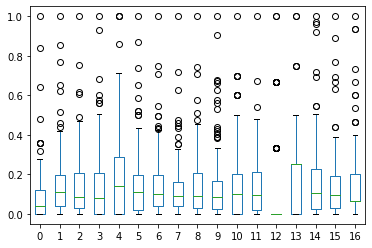

In [49]:
np_scaled_stay.plot.box()

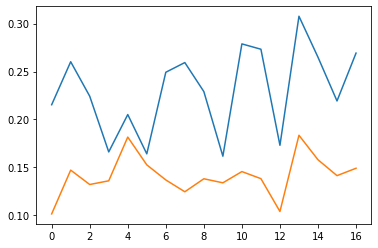

In [50]:
plt.plot(np_scaled_churn.mean().values)
plt.plot(np_scaled_stay.mean().values)

### 最后一步，用test测试集

In [51]:
test_results = dt.fit(test).transform(test)
print('测试集效果',f1score_model(test_results))

测试集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


## 补充2：尝试只用'active freq'，'About','Roll Advert'进行预测

In [52]:
assembler = VectorAssembler(inputCols = ['active_freq','About','Roll Advert'], outputCol = 'NumFeatures')
df = assembler.transform(spark_df)
# 归一化向量
scaler = Normalizer(inputCol =  'NumFeatures', outputCol = 'features')
df =  scaler.transform(df)

# 划分train, test, validation 数据集
train, test = df.select('features','label').randomSplit([0.75, 0.25], seed=42)
train, validation = train.randomSplit([0.75, 0.25], seed=42)

# 查看划分后的数据
train.groupBy('label').count().show()
validation.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  103|
|    1|   36|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   31|
|    1|    6|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   39|
|    1|   10|
+-----+-----+



In [53]:
# ··········逻辑回归··········
log_reg = LogisticRegression(labelCol = 'label').fit(train)

### 在测试数据集中评估模型，返回对象为BinaryLogisticRegressionSummary- 给定模型的二元逻辑回归结果
train_results = log_reg.evaluate(train).predictions
val_results = log_reg.evaluate(validation).predictions

print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall   f1score
0   0.833333  0.798561  0.277778  0.416667
验证集效果    precision  accuracy    recall   f1score
0   0.333333  0.810811  0.166667  0.222222


In [54]:
# ··········决策树··············
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=10, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall  f1score
0   0.892857  0.899281  0.694444  0.78125
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


In [55]:
# ··········决策树··············
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", maxDepth=20, maxBins=14)
temp_model = dt.fit(train)
train_results = temp_model.transform(train)
val_results = dt.fit(validation).transform(validation)
print('训练集效果',f1score_model(train_results))
print('验证集效果',f1score_model(val_results))

训练集效果    precision  accuracy    recall  f1score
0   0.892857  0.899281  0.694444  0.78125
验证集效果    precision  accuracy  recall  f1score
0        1.0       1.0     1.0      1.0


In [56]:
test_results = dt.fit(test).transform(test)
print('测试集效果',f1score_model(test_results))

测试集效果    precision  accuracy  recall   f1score
0        1.0  0.979592     0.9  0.947368
